# Problem 1:
Prepare a model for glass classification using KNN

## import necessary libraries

In [1]:
#%pip install imbalanced-learn

In [2]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score

from imblearn.over_sampling import SMOTE
from collections import Counter

In [3]:
%matplotlib inline



# Matplotlib configurations

# Display interactive plots. Used this since convenient for displaying plots in github.
# %matplotlib notebook
%matplotlib notebook
# Font and figure size:
# Ref: https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
SMALL_SIZE = 8
MEDIUM_SIZE = 9
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title



## Load data

In [4]:
glass_df = pd.read_csv('glass.csv')

In [5]:
glass_df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


## EDA

In [6]:
glass_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


In [7]:
glass_df['Type'].unique()

array([1, 2, 3, 5, 6, 7], dtype=int64)

In [8]:
X = glass_df.iloc[:, :-1]
y = glass_df.iloc[:, -1]

In [9]:
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

In [10]:
numeric_cols

Index(['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe'], dtype='object')

<IPython.core.display.Javascript object>


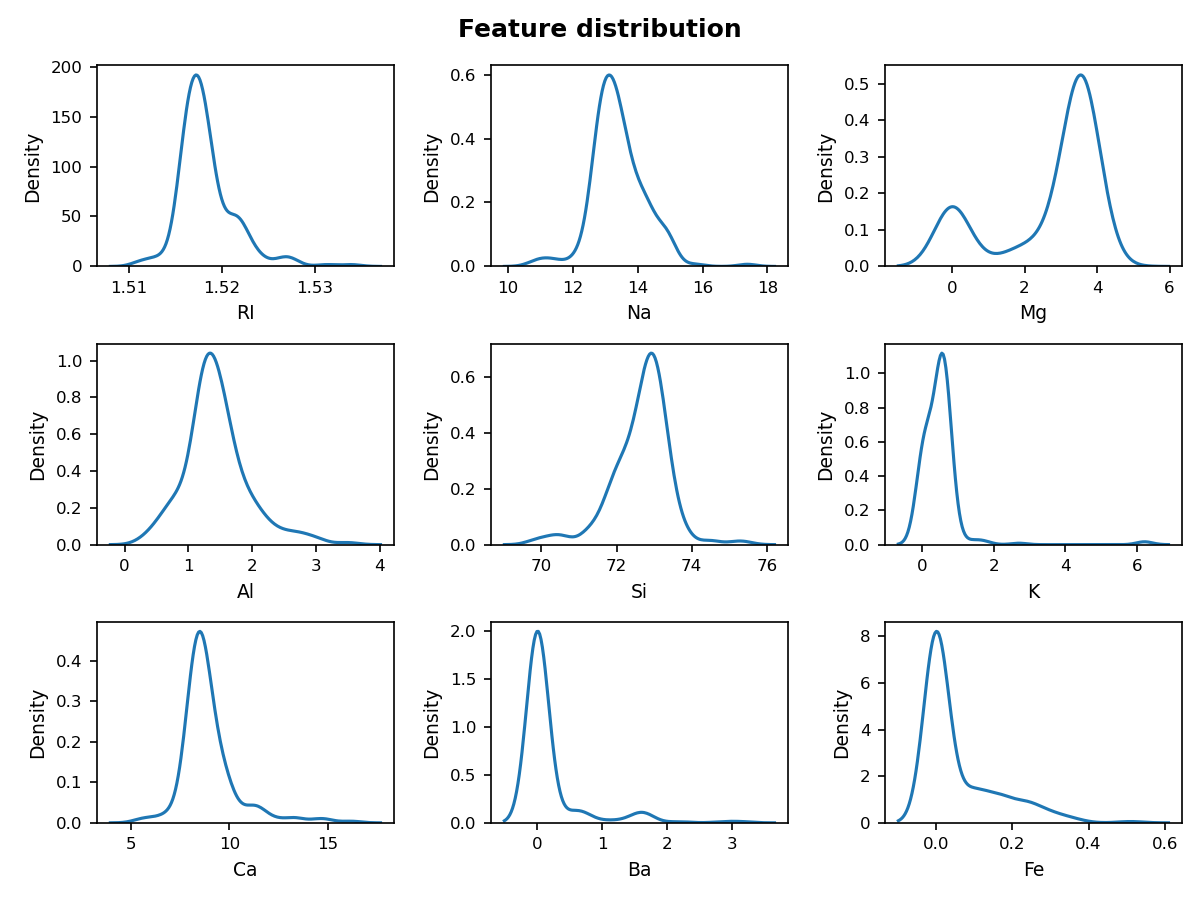

In [11]:
# Distribution of input features 
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8,6))
axes = axes.flatten()

for idx, ax in enumerate(axes):
    sns.kdeplot(data=X, x=X[numeric_cols[idx]], ax=ax)

fig.suptitle('Feature distribution', ha='center', fontweight='bold')
fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


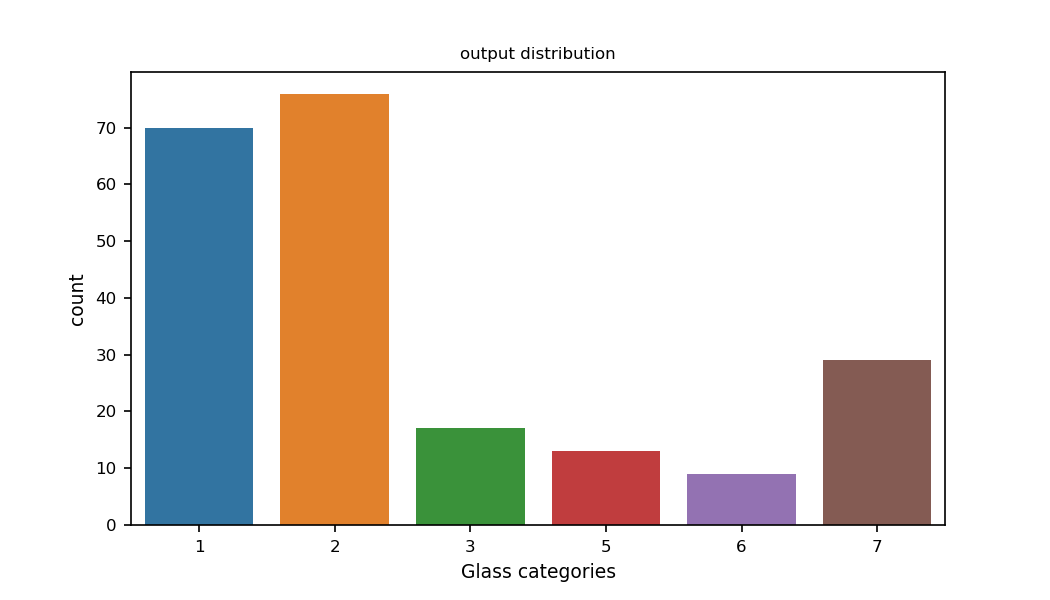

In [12]:
# Distribution of target labels.
fig, ax = plt.subplots()
sns.countplot(x=y) #since on the x axis , we have y labels.
ax.set_xlabel('Glass categories')
ax.set_ylabel('count')
ax.set_title('output distribution')
plt.show()

In [13]:
# Summarizing the y distribution.
def y_count_cat(df):
    """Function to print out the number of samples in 
    each category
    Input:
    ------
    y: y column
    
    output:
    -------
    Prints the class label, number of samples, and % wrt 
    to total no of samples."""
    
    count_org_cat = Counter(df)
    for k,v in count_org_cat.items():
        per = v/len(df)*100
        print('Class = {}, n = {} ({:.3f}%)'.format(k,v,per))

In [14]:
y_count_cat(y)

Class = 1, n = 70 (32.710%)
Class = 2, n = 76 (35.514%)
Class = 3, n = 17 (7.944%)
Class = 5, n = 13 (6.075%)
Class = 6, n = 9 (4.206%)
Class = 7, n = 29 (13.551%)


## Observations:
- 214 records, 9 features and 1 output column
- No null values.
- All features **except refractive index(unitless)** are in same units (weight %).
- All features are recorded with correct datatypes.
- Modt of the features are not nrmally distributed (except for density and refractive index which seem to have some kurtosis).
- 6 output categories.
- output distribution is imbalanced, with most off the glass samples falling under categories 2 and 1, with category 2 having slightly more members.

## Data preprocessing

## Model building

In [15]:
# Define scaler
scaler = StandardScaler()#Normalizer()->ok, #MinMaxScaler()-> bad
numeric_transformer = Pipeline(steps=[
    ('scaler', scaler)
])

In [16]:
# define preprocessor.
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols)
])

In [17]:
# Kfold cross validation:
cv_scores = []
for i in range(1,31,1):
    knn_classifier = KNeighborsClassifier(n_neighbors=i)
    k_clf = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', knn_classifier)
                           ])#
    crv_scores = cross_val_score(estimator=k_clf, X=X, y=y, cv=4)
    cv_scores.append(crv_scores.mean())

### Visualiations - to find optimal k value

<IPython.core.display.Javascript object>


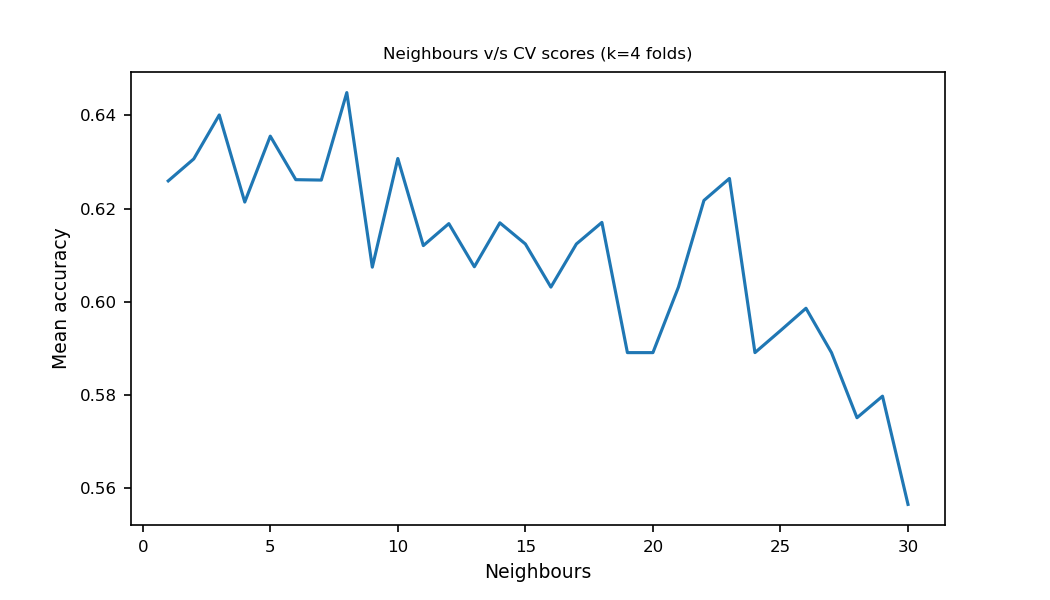

In [18]:
fig, ax = plt.subplots()
ax.plot(range(1, 31, 1), cv_scores)
ax.set_xlabel('Neighbours')
ax.set_ylabel('Mean accuracy')
plt.title('Neighbours v/s CV scores (k=4 folds)')
plt.show()


In [19]:
print('Max accuracy score from cross validation: {:.4f}'.format(max(cv_scores)))
print('Corresponding k value                   : {}'.format((cv_scores.index(max(cv_scores)))+1))

Max accuracy score from cross validation: 0.6449
Corresponding k value                   : 8


## Observations:
- from the iterations for different values of k and cross validation, we find that for k=3, we get the maximum accuracy.
- The maximum accuracy score after cross validation is only ~0.65, which is very poor. This could be due to the imbalance in the sample dataset, with more number of samples for the 1 and 2 class.

## SMOTE for handling imbalanced data like the Glass dataset
Ref: https://machinelearningmastery.com/multi-class-imbalanced-classification/

**Note**: SMOTE oversamples all classes to have the same number of examples as the class with the most examples(in our case, class 2).

In [20]:
oversample = SMOTE()

In [21]:
X_os, y_os = oversample.fit_resample(X,y)

<IPython.core.display.Javascript object>


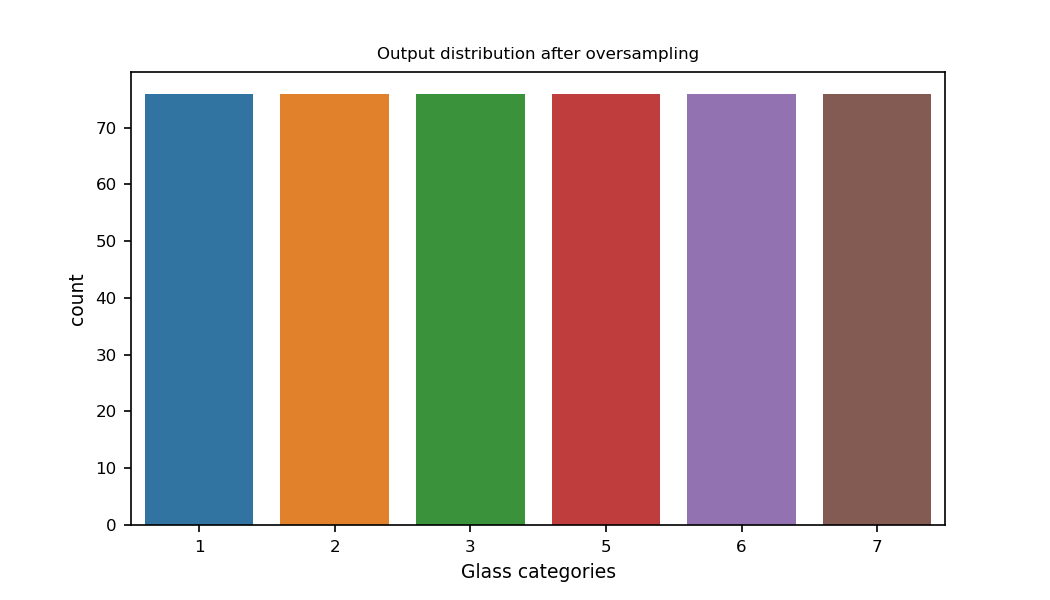

In [22]:
# Distribution of target labels.
fig, ax = plt.subplots()
sns.countplot(x=y_os) #since on the x axis , we have y labels.
ax.set_xlabel('Glass categories')
ax.set_ylabel('count')
ax.set_title('Output distribution after oversampling')
plt.show()

In [23]:
# Summary of the labels for oversampled distribution
y_count_cat(y_os)

Class = 1, n = 76 (16.667%)
Class = 2, n = 76 (16.667%)
Class = 3, n = 76 (16.667%)
Class = 5, n = 76 (16.667%)
Class = 6, n = 76 (16.667%)
Class = 7, n = 76 (16.667%)


In [24]:
# Kfold cross validation:
cv_scores_os = []
for i in range(1,31,1):
    knn_classifier_os = KNeighborsClassifier(n_neighbors=i)
    k_clf_os = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', knn_classifier_os)
                           ])#
    crv_scores_os = cross_val_score(estimator=k_clf_os, X=X_os, y=y_os, cv=5)
    cv_scores_os.append(crv_scores_os.mean())

### Visualiations - to find optimal k value

<IPython.core.display.Javascript object>


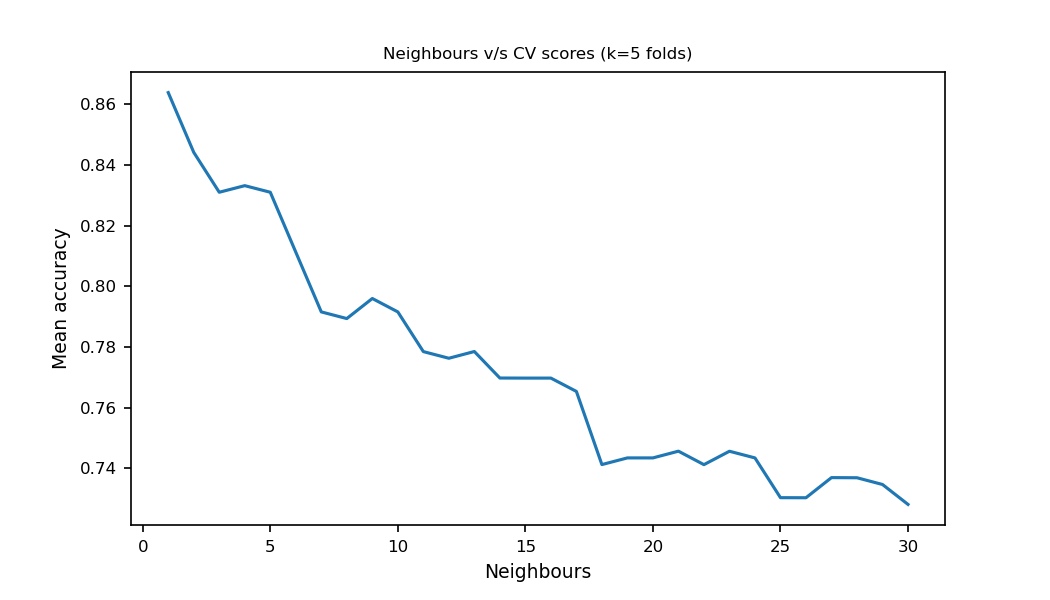

In [25]:
fig, ax = plt.subplots()
ax.plot(range(1, 31, 1), cv_scores_os)
ax.set_xlabel('Neighbours')
ax.set_ylabel('Mean accuracy')
plt.title('Neighbours v/s CV scores (k=5 folds)')
plt.show()

In [26]:
print('Max accuracy score from cross validation: {:.4f}'.format(max(cv_scores_os)))
print('Corresponding k value                   : {}'.format((cv_scores_os.index(max(cv_scores_os)))+1))

Max accuracy score from cross validation: 0.8639
Corresponding k value                   : 1


## Final model - on all data (after SMOTE)

In [27]:
knn_classifier_os = KNeighborsClassifier(n_neighbors=1)
k_clf_os = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', knn_classifier_os)
                           ])

In [28]:
k_clf_os.fit(X_os, y_os)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe'], dtype='object'))])),
                ('classifier', KNeighborsClassifier(n_neighbors=1))])

In [29]:
y_pred = k_clf_os.predict(X)

In [30]:
print('Accuracy score for final model: {}'.format(accuracy_score(y, y_pred)))

Accuracy score for final model: 1.0


**Note:** Since only the training dataset was provided, at best, the model will perform perfectly on the training set. The real test for the model is when a test dataset is provided to the model. Thus by cross validation, we can conclude that the classification accuracy of the model will be ~0.86.

## Conclusions:
- A KNN classifier was used to classify the glass types in the sample dataset provided. 